In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Standardize the training data to have columwise mean 0 and variance 1. Standardize test data based on training data parameters. 
def standardize_data(X_train, X_test):
    # Get the column-wise means and standard deviations from the data.
    td_means = torch.nanmean(X_train, axis=0)
    td_std = torch.std(X_train, axis=0)
    mask = td_std == 0

    # Normalize the train data.
    X_train_normed = X_train.clone()
    X_train_normed[:, mask] = td_means[mask]
    X_train_normed[:, ~mask] = (X_train_normed[:, ~mask] - td_means[~mask]) / td_std[~mask]

    # Normalize the test data.
    X_test_normed = X_test.clone()
    X_test[:, mask] = td_means[mask]
    X_test_normed[:, ~mask] = (X_test_normed[:, ~mask] - td_means[~mask]) / td_std[~mask]

    return X_train_normed, X_test_normed

def prepare_data():
    # Load the data.
    train = pd.read_csv('mnist_train.csv')
    test = pd.read_csv('mnist_test.csv')
    x_train, y_train = train.drop(columns=['label']).to_numpy(), train['label'].to_numpy()
    x_test, y_test = test.drop(columns=['label']).to_numpy(), test['label'].to_numpy()

    # Pass the data to torch tensors to make the processing faster with CUDA.
    X_train = torch.tensor(x_train, dtype=torch.float32, device='cuda')
    Y_train = torch.tensor(y_train, dtype=torch.float32, device='cuda')
    X_test = torch.tensor(x_test, dtype=torch.float32, device='cuda')
    Y_test = torch.tensor(y_test, dtype=torch.float32, device='cuda')

    # Standardize the data.
    X_train, X_test = standardize_data(X_train, X_test)
    
    # Compute the SVD of X_train.
    [U, S, V_trans] = torch.linalg.svd(X_train, full_matrices=False)

    # Find the number k of singular values that capture 95% of the data variance.
    explained_var = S ** 2
    total_var = torch.sum(explained_var)
    cum_var_ratio = torch.cumsum(explained_var, dim=0) / total_var 
    k = torch.where(cum_var_ratio >= 0.95)[0][0].item()
    
    # Get a reduced version of V_trans (first k columns of V.T).
    V_trans_k = V_trans[:k, :]

    # Print out k.
    print("Number of modes needed to preserve 95% of variance:", k)

    # Reduce the data dimension by projecting onto a lower dimensional space.
    X_train_reduced = X_train @ V_trans_k.T
    X_test_reduced = X_test @ V_trans_k.T

    return X_train_reduced, Y_train, X_test_reduced, Y_test

# Select a subset of 2 digits fro mthe training data and normalize again.
def select_digits(digits, X_train, Y_train, X_test, Y_test):
    # Unpack the digits.
    digit_1, digit_2 = digits

    # Split the data based on the digits.
    # Convention X, Y is training data and Xt, Yt is test data.
    mask_train = (Y_train == digit_1) | (Y_train == digit_2)
    X = X_train[mask_train]
    Y = Y_train[mask_train]
    mask_test = (Y_test == digit_1) | (Y_test == digit_2)
    Xt = X_test[mask_test]
    Yt = Y_test[mask_test]

    # Standardize.
    X, Xt = standardize_data(X, Xt)

    # Map Y data to +1 and -1.
    Y = torch.where(Y == digit_1, 1.0, -1.0)
    Yt = torch.where(Yt == digit_1, 1.0, -1.0)

    # Return the normalzied subset of data.
    return X, Y, Xt, Yt
    
# Make an RBF kernel.
def rbf_kernel(A, B, l):
    A_norm = (A ** 2).sum(dim=1).unsqueeze(1)  # (m, 1).
    B_norm = (B ** 2).sum(dim=1).unsqueeze(0)  # (1, p).
    cross_term = A @ B.T                       # (m, p).
    dists_squared = A_norm + B_norm - 2 * cross_term  # (m, p).
    dists_squared = torch.clamp(dists_squared, min=0.0)
    return torch.exp(-dists_squared / (l ** 2))

# Make a linear kernel.
def linear_kernel(A, B, l=0):
    return A @ B.T

# Make a polynomial kernel, say quintic.
def quintic_kernel(A, B, l=0):
    return (1 + A @ B.T) ** 5

# Return the fittted classification function.
def kernel_classifier_func(X, Y, l, gamma, kernel_func):
    # Make kernel matrix from training data.
    K = kernel_func(A=X, B=X, l=l)
    B = torch.linalg.solve(K + gamma * torch.eye(K.shape[0], device='cuda'), Y)
    # Define trained classifier.
    def func(x_in):
        return torch.sign(kernel_func(A=x_in, B=X, l=l) @ B)
    return func

# Make a kernel classifier to classifiy between 2 numbers in the MNIST data set.
# Here digits is a 2-tuple (digit_1, digit_2)
# Assume the training/testing data X_train/X_test is already standardized and reduced via PCA.
def kernel_classifier(X_train, Y_train, X_test, Y_test, digits, l, gamma, kernel_func):
    # Select the subset of data we want, and re-standardize.
    X, Y, Xt, Yt = select_digits(digits, X_train, Y_train, X_test, Y_test)

    # Train model.
    trained_func = kernel_classifier_func(X, Y, l, gamma, kernel_func)

    # Try on training data.
    Y_hat_train = trained_func(X)
    Y_hat_train[Y_hat_train == 0] = 1
    
    # Try on test data.
    Y_hat_test = trained_func(Xt)
    Y_hat_test[Y_hat_test == 0] = 1

    # Compute the training accuracy.
    num_correct_train = torch.sum((Y_hat_train - Y) == 0)
    num_train = Y.shape[0]
    acc_train = num_correct_train / num_train
    
    # Compute test accuracy.
    num_correct_test = torch.sum((Y_hat_test - Yt) == 0)
    num_test = Yt.shape[0]
    acc_test = num_correct_test / num_test

    return acc_train, acc_test

def test_params(X_train, Y_train, X_test, Y_test, digits):
    # Set paramters for testing.
    gamma_vals = [1e-2, 1e-1, 1, 10, 100, 1000]
    l_vals = [1e-2, 1e-1, 1, 10, 100, 1000]

    # For linear kernel, test gamma only.
    linear_train_accs = np.zeros(6)
    linear_test_accs = np.zeros(6)
    for i, gamma in enumerate(gamma_vals):
        acc_train, acc_test = kernel_classifier(X_train, Y_train, X_test, Y_test, digits, l=0, gamma=gamma, kernel_func=linear_kernel)
        linear_train_accs[i] = acc_train
        linear_test_accs[i] = acc_test
        print("Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) =", (gamma, acc_train.item(), acc_test.item()))
    print("")

    # For quintic kernel, test gamma only.
    quintic_train_accs = np.zeros(6)
    quintic_test_accs = np.zeros(6)
    for i, gamma in enumerate(gamma_vals):
        acc_train, acc_test = kernel_classifier(X_train, Y_train, X_test, Y_test, digits, l=0, gamma=gamma, kernel_func=quintic_kernel)
        quintic_train_accs[i] = acc_train
        quintic_test_accs[i] = acc_test
        print("Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) =", (gamma, acc_train.item(), acc_test.item()))
    print("")

    # For RBF kernel, test gamma and scale (l).
    rbf_train_accs = np.zeros((6, 6))
    rbf_test_accs = np.zeros((6, 6))
    for i, gamma in enumerate(gamma_vals):
        for j, l in enumerate(l_vals):
            acc_train, acc_test = kernel_classifier(X_train, Y_train, X_test, Y_test, digits, l=l, gamma=gamma, kernel_func=rbf_kernel)
            rbf_train_accs[i, j] = acc_train
            rbf_test_accs[i, j] = acc_test
            print("RBF Kernel: (Gamma, Scale, Train Accuracy, Test Accuracy) =", (gamma, l, acc_train.item(), acc_test.item()))
    print("")

    # 2D Plot for Linear and Quintic kernels.
    fig, ax = plt.subplots()
    plt.xlabel("Gamma")
    plt.ylabel("Accuracy")
    plt.xscale('log')
    plt.plot(gamma_vals, linear_train_accs, label="Linear Kernel Train")
    plt.plot(gamma_vals, linear_test_accs, label="Linear Kernel Test")
    plt.plot(gamma_vals, quintic_train_accs, label="Quintic Kernel Train")
    plt.plot(gamma_vals, quintic_test_accs, label="Quintic Kernel Test")
    plt.title("Linear and Quintic Accuracy vs. Gamma")
    plt.legend()
    plt.show()

    # 3D Plot for RBF kernel.
    gamma_grid, l_grid = np.meshgrid(np.array(gamma_vals), np.array(l_vals))
    fig_3d = plt.figure()
    ax_3d = fig_3d.add_subplot(111, projection='3d')
    ax_3d.plot_surface(np.log10(gamma_grid), np.log10(l_grid), rbf_train_accs.T, color='blue')
    ax_3d.plot_surface(np.log10(gamma_grid), np.log10(l_grid), rbf_test_accs.T, color='red')
        
    # Set labels.
    ax_3d.set_xlabel('log10(Gamma)')
    ax_3d.set_ylabel('log10(Scale)')
    ax_3d.set_zlabel('Accuracy')
    ax_3d.set_title('RBF Kernel: Accuracy vs. Hyperparameters (Train = Blue, Test = Red)')
    plt.show()

In [4]:
# Get data.
X_train, Y_train, X_test, Y_test = prepare_data()

(60000, 784)
(10000, 784)
Number of modes needed to preserve 95% of variance: 330


Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.01, 0.95240718126297, 0.9626865386962891)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.1, 0.9950358271598816, 0.9934701323509216)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (1, 0.9958238005638123, 0.9948693513870239)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (10, 0.9955874085426331, 0.9948693513870239)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (100, 0.9956662058830261, 0.9948693513870239)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (1000, 0.9952722191810608, 0.9939365386962891)

Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.01, 0.9971632957458496, 0.9939365386962891)
Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.1, 0.9971632957458496, 0.9939365386962891)
Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (1, 0.9971632957458496, 0.9939365386962891)
Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (10, 0.9971632957458496, 

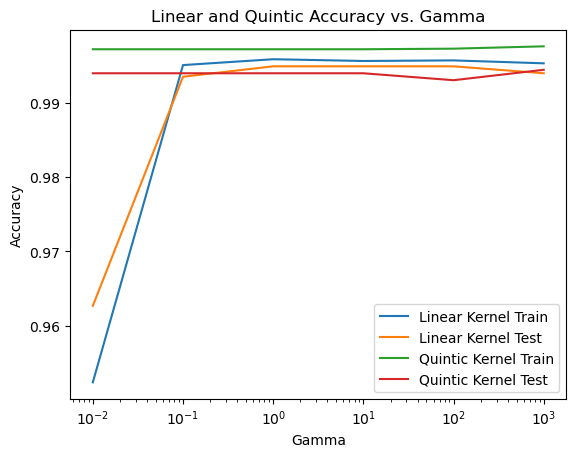

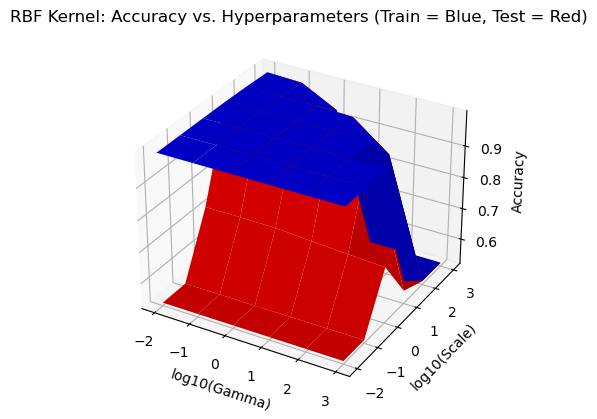

In [5]:
# For digits (1, 9).
test_params(X_train, Y_train, X_test, Y_test, digits=(1, 9))

Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.01, 0.9389083981513977, 0.9314515590667725)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.1, 0.9643632173538208, 0.9591733813285828)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (1, 0.9653647541999817, 0.9591733813285828)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (10, 0.9649474620819092, 0.9601814150810242)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (100, 0.9643632173538208, 0.9596773982048035)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (1000, 0.9643632173538208, 0.9591733813285828)

Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.01, 0.998831570148468, 0.9747983813285828)
Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.1, 0.998831570148468, 0.9747983813285828)
Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (1, 0.998831570148468, 0.9747983813285828)
Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (10, 0.998831570148468, 0.

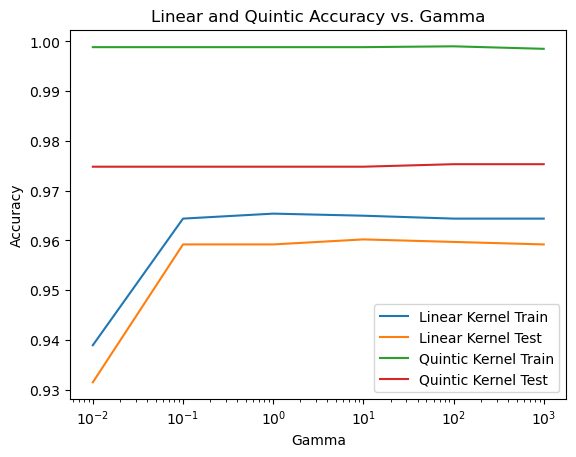

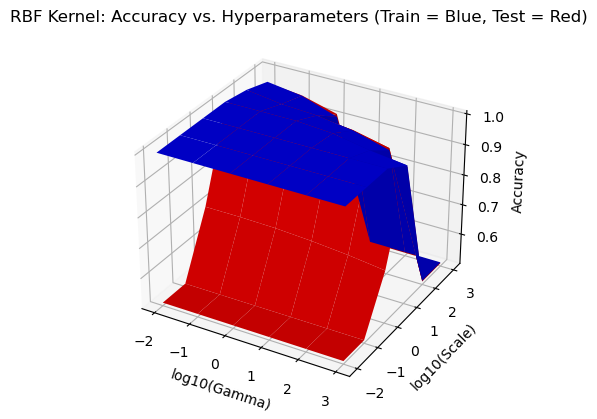

In [6]:
# For digits (3, 8).
test_params(X_train, Y_train, X_test, Y_test, digits=(3, 8))

Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.01, 0.9558699727058411, 0.962552011013031)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.1, 0.9932344555854797, 0.9889042973518372)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (1, 0.9936188459396362, 0.9893665909767151)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (10, 0.9936188459396362, 0.9893665909767151)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (100, 0.9930806756019592, 0.9902912378311157)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (1000, 0.9917737245559692, 0.989828884601593)

Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.01, 0.9912355542182922, 0.9796578288078308)
Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.1, 0.9912355542182922, 0.9796578288078308)
Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (1, 0.9912355542182922, 0.9796578288078308)
Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (10, 0.991389274597168, 0

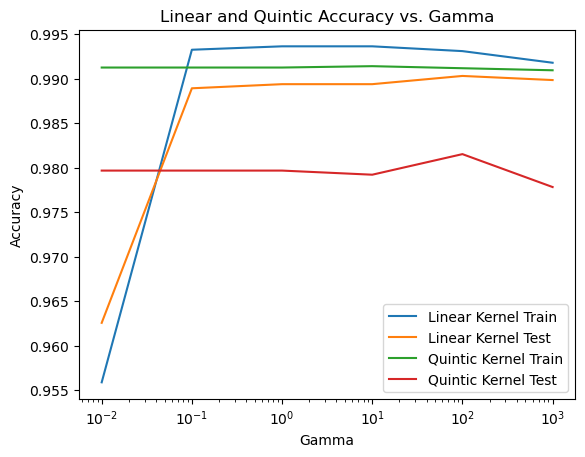

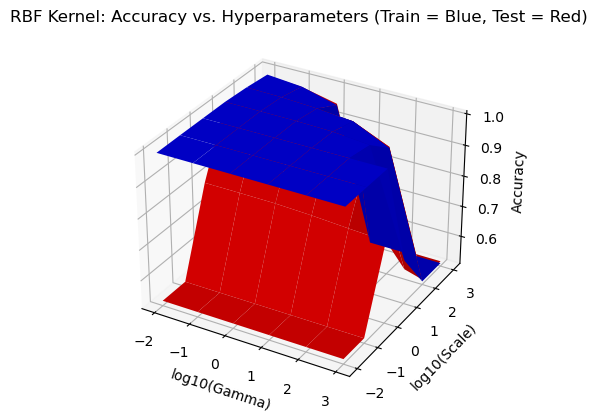

In [7]:
# For digits (1, 7).
test_params(X_train, Y_train, X_test, Y_test, digits=(1, 7))

Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.01, 0.957817018032074, 0.9656964540481567)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.1, 0.9789085388183594, 0.9776507616043091)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (1, 0.9802267551422119, 0.9792099595069885)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (10, 0.9800509810447693, 0.9807692170143127)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (100, 0.9800509810447693, 0.9792099595069885)
Linear Kernel: (Gamma, Train Accuracy, Test Accuracy) = (1000, 0.9796115756034851, 0.9802494645118713)

Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.01, 0.9992969632148743, 0.9854469895362854)
Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (0.1, 0.9992969632148743, 0.9854469895362854)
Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (1, 0.9992969632148743, 0.9854469895362854)
Quintic Kernel: (Gamma, Train Accuracy, Test Accuracy) = (10, 0.9992969632148743,

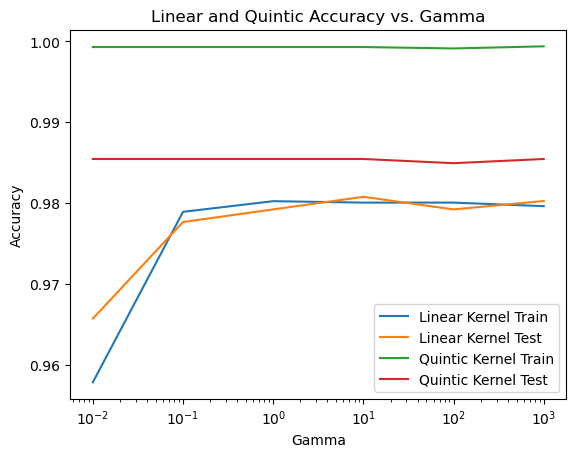

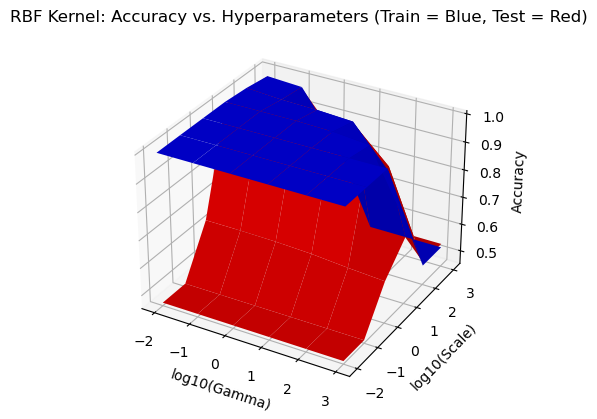

In [8]:
# For digits (1, 7).
test_params(X_train, Y_train, X_test, Y_test, digits=(5, 2))

In [9]:
print(X_train.shape)

torch.Size([60000, 330])


In [ ]:
def rbf_kernel(A, B, l):
    dists_squared = np.subtract.outer(A, B) ** 2
    return np.exp(-dists_squared / (2 * l))